In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.classes.function import path_weight

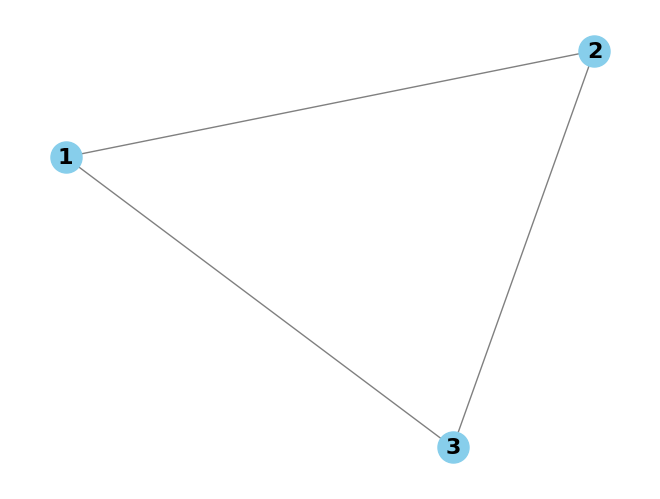

In [4]:
#  Exemplo de grafo simples

# Criação do grafo
G = nx.Graph()

# Adiciona nós
G.add_node(1)
G.add_node(2)
G.add_node(3)

# Adiciona arestas entre os nós
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 3)

# Desenho do grafo
nx.draw(G, with_labels=True, node_color="skyblue", node_size=500, font_size=16, font_weight="bold", edge_color="gray")
plt.show()


In [5]:
#  função criada pelo timber


def create_graph(transports):
    graph = {}

    # Creating the graph with the list of transports
    for i,transport in tqdm(transports.iterrows()):
        id_emp_orig = transport['node_src']
        id_emp_dest = transport['node_dest']

        volume = transport['vol']

        # Graph is a dict (source) -> (destination, weight)
        if graph.get(id_emp_orig) is None:
            # if source is not in the graph we need to map it as source to the destination
            graph[id_emp_orig] = {id_emp_dest: {'weight': volume }}
        else:
            # if source is already in the graph
            # 1. new destination from that source: create the edge
            # 2. source already mapped to destination: increase the volume in that edge
            if graph[id_emp_orig].get(id_emp_dest) is None:
                graph[id_emp_orig][id_emp_dest] = {'weight': volume }
            else:
                graph[id_emp_orig][id_emp_dest]['weight'] += volume

    # In this context we want to maximize paths over the volume
    # Since most functions minimizes over the weight of the edges,
    # we need to invert the relation
    for source, targets in graph.items():
        for target, volume in targets.items():
            graph[source][target]['weight'] = -1 * volume['weight']

    return nx.DiGraph(graph)

In [7]:
transportes_janeiro = pd.read_csv('./df_01.csv')

In [18]:
transportes_janeiro.head()

,Unnamed: 0.1,index,Unnamed: 0,Codigo,Registro,TpRegistro,OrigemID,NomeOrigem,CPF_CNPJ_Rem,CTFOrigem,...,NomePopular,NomeCientifico,Unidade,Volume,DtEmissao,Ano,Status,NomePopularAgregado,datetimeDtEmissao,ID
0,2,2,2,1564782366682124,17264225,DOF,PTO-73304982000189,EUNILO ROQUE DE ALMEIDA & CIA LTDA,73304982000189,17603,...,Arianá,Qualeaparaensis,M3,0.400,17/01/2017,2017,Emitido,Mandioqueiro,2017-01-17,2
1,3,3,3,3916745881826981,17289999,DOF,PTO-12019924000119,ALEFE RODRIGO SILVA ALVES & CIA LTDA ME,12019924000119,5089868,...,Cambará,Qualeaspp,M3,0.175,21/01/2017,2017,Emitido,Mandioqueiro,2017-01-21,3
2,4,4,4,3916745881826981,17289999,DOF,PTO-12019924000119,ALEFE RODRIGO SILVA ALVES & CIA LTDA ME,12019924000119,5089868,...,Cambarápreto,Qualeaparaensis,M3,0.385,21/01/2017,2017,Emitido,Mandioqueiro,2017-01-21,4
3,6,11,11,5958452782252322,17328675,DOF,PTO-01473384000122,MADEIREIRA BURANELLO LTDA. - ME,1473384000122,81103,...,Libra,Qualeaparaensis,M3,0.358,30/01/2017,2017,Emitido,Mandioqueiro,2017-01-30,6
4,18,72,72,8639776723649842,18816771,DOF,PTO-01473384000122,MADEIREIRA BURANELLO LTDA. - ME,1473384000122,81103,...,Cambarápreto,Qualeaalbiflora,M3,0.400,01/12/2017,2017,Emitido,Mandioqueiro,2017-01-12,18


In [15]:
transportes_janeiro['TpDes'].value_counts()

TpDes
FINAL        15316
PTO_IBAMA     7370
Name: count, dtype: int64

In [17]:
transportes_janeiro['TpRem'].value_counts()

TpRem
PTO_IBAMA    22449
MANEJO         237
Name: count, dtype: int64